## Say hello to `torch_dreams`

**What is it ?**
Torch-dreams is a python library that can be used as a tool to understand how neural networks build up their understanding of images. This is done through feature visualization. 

<img src = "https://github.com/Mayukhdeb/torch-dreams/raw/master/images/inceptionv3_cherrypicked_channels.jpg?raw=true">

If you want to know more about feature visualization, have a look at the following links:
* [Feature visualization by Olah, et al.](https://distill.pub/2017/feature-visualization/)
* [The enemy of feature visualization by Olah, et al.](https://distill.pub/2017/feature-visualization/#enemy-of-feature-vis)

## Getting started with visualizing the `inceptionV3`

`torch_dreams.dreamer` is a wrapper on top of a pytorch model which would run optimizations on the input image to maximize the activations of layer(s), channel(s), or even single unit(s) within the model.  

**Note**: If you're on google colab, **make sure you are on a GPU runtime** for better performance

In [1]:
!pip install torch-dreams --upgrade

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

import torchvision.models as models 

from torch_dreams.dreamer import dreamer

In [3]:
model = models.inception_v3(pretrained=True)
dreamy_boi = dreamer(model)

Downloading: "https://download.pytorch.org/models/inception_v3_google-1a9a5a14.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-1a9a5a14.pth



dreamer init on:  cuda


In [4]:
!wget https://raw.githubusercontent.com/Mayukhdeb/torch-dreams/master/images/noise.jpg

--2020-11-23 04:41:03--  https://raw.githubusercontent.com/Mayukhdeb/torch-dreams/master/images/noise.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 307456 (300K) [image/jpeg]
Saving to: ‘noise.jpg’

noise.jpg           100%[===================>] 300.25K  --.-KB/s    in 0.02s   

2020-11-23 04:41:03 (13.5 MB/s) - ‘noise.jpg’ saved [307456/307456]



## First off, let's optimize some random noise to maximize layer activations within the `inceptionV3`

**Step 1**: Select the layer to be optimized 

**Step 2**: Run `dreamer.deep_dream()` with your hyperparameters.

To try it out on different layers, set: `layer = model.your_layer_name`


In [5]:
layer = model.Mixed_5d
layers_to_use = [layer]

In [ ]:

out_single_layer = dreamy_boi.deep_dream(
    image_path = "noise.jpg",
    layers = layers_to_use,
    octave_scale = 1.3,
    num_octaves = 7,
    iterations = 100,
    lr = 0.9
)

 88%|████████▊ | 7/8 [04:38<00:58, 58.32s/it]

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize = (14,6))

ax.flat[0].imshow(cv2.imread("noise.jpg"))
ax.flat[0].set_title("noise", fontsize = 18)
ax.flat[0].axis("off")

ax.flat[1].imshow(out_single_layer)
ax.flat[1].axis("off")
ax.flat[1].set_title("inceptionv3.Mixed_5d", fontsize = 18)


## Visualizing 2 conv layers individually first, and then simultaneously

In [ ]:
layers_to_use = [
    model.Mixed_6c.branch7x7_1.conv,
    model.Mixed_6a.branch3x3dbl_1.conv ## feel free to change these layers
]

Text(0.5, 1.0, 'model.Mixed_6a.branch3x3dbl_1.conv')

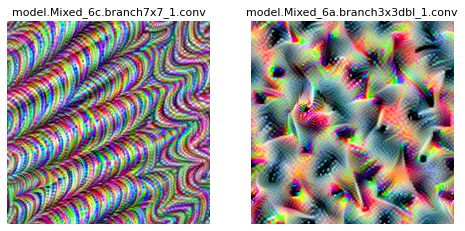

In [ ]:
out_layer_1 = dreamy_boi.deep_dream(
    image_path = "noise.jpg",
    layers = layers_to_use[:1],  ## using only  model.Mixed_6c.branch7x7_1.conv
    octave_scale = 1.1,
    num_octaves = 11,
    iterations = 100,
    lr = 4.9,
    custom_func = None
)

out_layer_2 = dreamy_boi.deep_dream(
    image_path = "noise.jpg",
    layers = layers_to_use[-1:],  ## using only model.Mixed_6a.branch3x3dbl_1.conv
    octave_scale = 1.1,
    num_octaves = 11,
    iterations = 100,
    lr = 4.9,
    custom_func = None
)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize = (8,4))
ax.flat[0].imshow(out_layer_1)
ax.flat[0].set_title("model.Mixed_6c.branch7x7_1.conv", fontsize = 11)
ax.flat[0].axis("off")

ax.flat[1].imshow(out_layer_2)
ax.flat[1].axis("off")
ax.flat[1].set_title("model.Mixed_6a.branch3x3dbl_1.conv", fontsize = 11)


## Let's optimize the 2 conv layers simultaneously by using the `custom_func`

Notice how we've altered the `custom_func` to include both the layer's outputs with `loss = layer_outputs[0].norm()  + layer_outputs[1].norm() `

`layer_outputs` is a list that contains the outputs of the layers mentioned in the `layers` argument.

In [ ]:
def optimize_2_layers(layer_outputs):
    """
    You can alter this function to use as many layers as you want
    Just make sure you also include them in the layers argument
    """
    loss = layer_outputs[0].norm()  + layer_outputs[1].norm() 
    
    return loss

out_layer_blend = dreamy_boi.deep_dream(
    image_path = "noise.jpg",
    layers = layers_to_use,   ## the outputs of these layers would be passed into the custom_func
    octave_scale = 1.1,
    num_octaves = 11,
    iterations = 100,
    lr = 4.9,
    custom_func = optimize_2_layers
)

100%|██████████| 12/12 [00:40<00:00,  3.39s/it]


Text(0.5, 1.0, 'Blend')

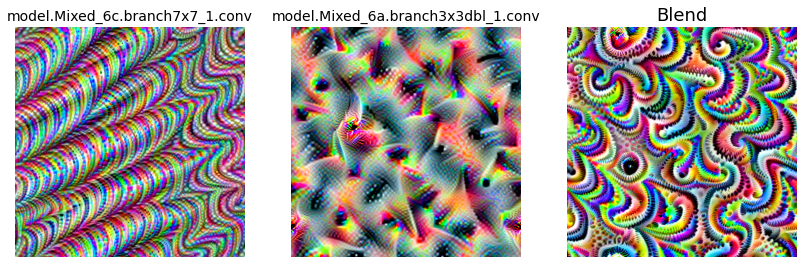

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize = (14,6))

ax.flat[0].imshow(out_layer_1)
ax.flat[0].set_title("model.Mixed_6c.branch7x7_1.conv", fontsize = 14)
ax.flat[0].axis("off")

ax.flat[1].imshow(out_layer_2)
ax.flat[1].axis("off")
ax.flat[1].set_title("model.Mixed_6a.branch3x3dbl_1.conv", fontsize = 14)

ax.flat[2].imshow(out_layer_blend)
ax.flat[2].axis("off")
ax.flat[2].set_title("Blend", fontsize = 18)


## Visualizing 2 channels individually first, and then simultaneously

In [ ]:
layers_to_use = [model.Mixed_6c.branch7x7_1.conv]

In [ ]:
def optimize_6th_channel(layer_outputs):
    loss = layer_outputs[0][6].norm()   ## 6th channel
    return loss

out_single_channel_1 = dreamy_boi.deep_dream(
    image_path = "noise.jpg",
    layers = layers_to_use,
    octave_scale = 1.2,
    num_octaves = 8,
    iterations = 200,
    lr = 5.9,
    custom_func =  optimize_6th_channel,
    max_rotation =  0.3
)

def optimize_7th_channel(layer_outputs):
    loss = layer_outputs[0][7].norm()   ## 6th channel
    return loss

out_single_channel_2 = dreamy_boi.deep_dream(
    image_path = "noise.jpg",
    layers = layers_to_use,
    octave_scale = 1.2,
    num_octaves = 8,
    iterations = 200,
    lr = 5.9,
    custom_func =  optimize_7th_channel,
    max_rotation =  0.3
)

100%|██████████| 9/9 [00:48<00:00,  5.40s/it]


Text(0.5, 1.0, 'model.Mixed_6a.branch3x3dbl_1.conv_channel_7')

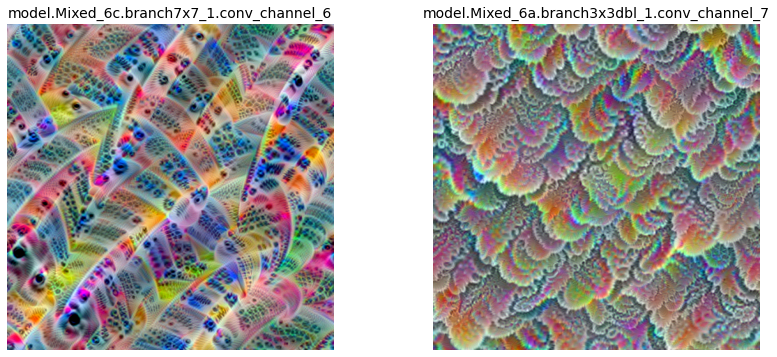

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize = (14,6))

ax.flat[0].imshow(out_single_channel_1)
ax.flat[0].set_title("model.Mixed_6c.branch7x7_1.conv_channel_6", fontsize = 14)
ax.flat[0].axis("off")

ax.flat[1].imshow(out_single_channel_2)
ax.flat[1].axis("off")
ax.flat[1].set_title("model.Mixed_6a.branch3x3dbl_1.conv_channel_7", fontsize = 14)


## Visualizing 2 channels simultaneously


Notice how we've altered the `custom_func` to include both the channels with `loss = layer_outputs[0][7].norm()  + layer_outputs[0][6].norm() ` i.e adding the activations of the 7th and 6th channel


In [ ]:
def optimize_both_channels(layer_outputs):
    loss = layer_outputs[0][7].norm()   + layer_outputs[0][6].norm() 
    return loss

out_blend_channels = dreamy_boi.deep_dream(
    image_path = "noise.jpg",
    layers = layers_to_use,
    octave_scale = 1.2,
    num_octaves = 8,
    iterations = 200,
    lr = 5.9,
    custom_func =  optimize_both_channels,
    max_rotation =  0.3
)

100%|██████████| 9/9 [00:48<00:00,  5.39s/it]


Text(0.5, 1.0, 'blend both channels')

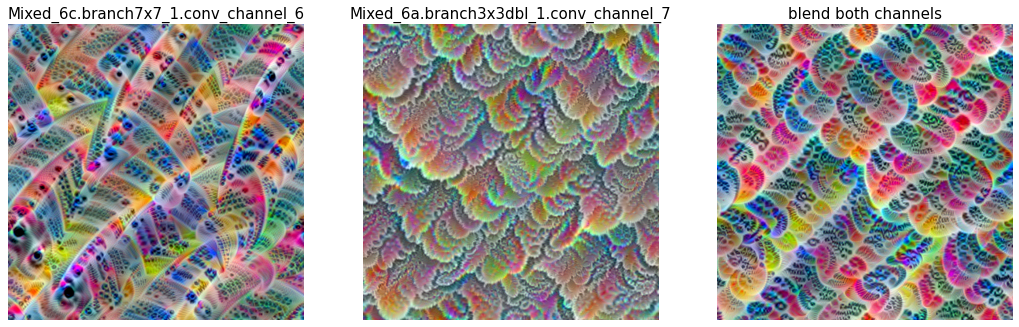

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize = (18,10))

ax.flat[0].imshow(out_single_channel_1)
ax.flat[0].set_title("Mixed_6c.branch7x7_1.conv_channel_6", fontsize = 15)
ax.flat[0].axis("off")

ax.flat[1].imshow(out_single_channel_2)
ax.flat[1].axis("off")
ax.flat[1].set_title("Mixed_6a.branch3x3dbl_1.conv_channel_7", fontsize = 15)

ax.flat[2].imshow(out_blend_channels)
ax.flat[2].axis("off")
ax.flat[2].set_title("blend both channels", fontsize = 15)


## Optimizing one single unit within a channel

In [ ]:

def optimize_1_unit(layer_outputs):
    """
    You can alter this function to use as many layers as you want
    Just make sure you also include them in the layers argument
    """
    loss = layer_outputs[0][100][0][0].norm()

    return loss

out_unit_1 = dreamy_boi.deep_dream(
    image_path = "noise.jpg",
    layers = layers_to_use[:1],  ## using only model.Mixed_6c.branch7x7_1.conv
    octave_scale = 1.1,
    num_octaves = 16,
    iterations = 250,
    lr = 8.9,
    custom_func = optimize_1_unit
)

100%|██████████| 17/17 [01:56<00:00,  6.87s/it]


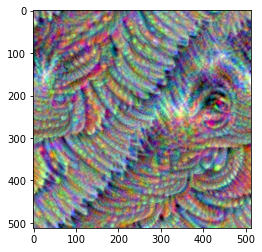

In [ ]:
plt.imshow(out_unit_1)
plt.show()

## Creating interpolations between channels 

In [8]:
layer = model.Mixed_6c.branch7x7_1.conv
layers_to_use = [layer]

In [27]:
cherry_picked_indices = [4, 6, 16, 7]
# cherry_picked_indices = [16,7]

In [ ]:
# all_channel_activations = []
alphas = np.linspace(0, 1, 6)

for i in range(len(cherry_picked_indices)-1):

    for alpha in alphas:
        def my_custom_func(layer_outputs):
            loss = layer_outputs[0][cherry_picked_indices[i]].norm()*(1-alpha) +layer_outputs[0][cherry_picked_indices[i+1]].norm()*(alpha)
            return loss

        out = dreamy_boi.deep_dream(
            image_path = "noise.jpg",
            layers = layers_to_use,
            octave_scale = 1.2,
            num_octaves = 9,
            iterations = 200,
            lr = 6.9,
            custom_func =  my_custom_func,
            max_rotation =  0.3
        )
        all_channel_activations.append(out)
        # plt.imshow(out)
        # plt.show()

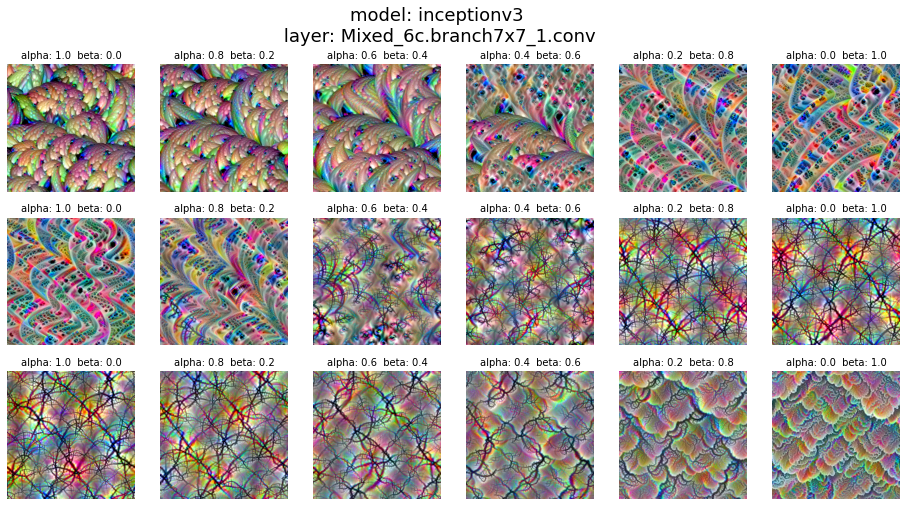

In [45]:
fig, ax = plt.subplots(nrows=3, ncols=6, figsize = (16,8))
fig.suptitle('model: inceptionv3 \n layer: Mixed_6c.branch7x7_1.conv \n', fontsize=18)

for i in range(len(all_channel_activations)):
    # print(alphas[i])

    title = "alpha: " + str(round(1 - alphas[i%len(alphas)], 2)) + "  beta: " + str(round(alphas[i%len(alphas)],2))
    ax.flat[i].imshow(all_channel_activations[i])
    ax.flat[i].set_title(title, fontsize = 10)
    ax.flat[i].axis("off")
